## This script:
### -Imports optimized hyperparameters from Sagemaker UI initiated tuning job
### -Trains an optimized model using these hyperparameters
### -Deploys this optimized model 
### -Facilitates real-time inference calls to the model
### -Assesses this model in terms of statistical prowess
<br><br>
### Outline of Notebook:

#### 3.1 Establish environment and define appropriate variables
#### 3.2 Import Hyperparameters
#### 3.3 Train Optimized Model
#### 3.4 Deploy Optimized Model for Real Time Inference Calls via Gateway API and Lambda
#### 3.5 Identify Optimal Likelihood Cutoff for our Predictions
#### 3.6 Evaluate Model<br>
&nbsp;&nbsp;&nbsp;&nbsp;Function: <u>CSV_Reader()</u><br>
&nbsp;&nbsp;&nbsp;&nbsp;Function: <u>Linear_Learner_Statistical_Evaluation()</u><br>
&nbsp;&nbsp;&nbsp;&nbsp;Function: <u>Plot_Confusion_Matrix()</u>

### 3.1 Establish environment and define appropriate variables

In [1]:
'''The first step is to import the necessary libraries'''

#Data manipulation libraries
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import random as random
from datetime import datetime
from sklearn.utils import shuffle
from time import gmtime, strftime
%matplotlib inline

#Data visualization libraries
import seaborn as sns
import matplotlib.pyplot as plt

#AWS Sagemaker libraries
import sagemaker
import boto3
import io
from io import StringIO
from sagemaker import get_execution_role
import sagemaker.amazon.common as smac
import os
from sagemaker.tuner import IntegerParameter, ContinuousParameter, HyperparameterTuner
from sagemaker.amazon.amazon_estimator import get_image_uri
from sagemaker.session import s3_input

#Libraries needed to evaluate the machine learning models
from sklearn.metrics import precision_recall_fscore_support
from sklearn.metrics import accuracy_score
from sklearn.metrics import roc_auc_score

#Defining some global variables for Sagemaker
region = boto3.Session().region_name
smclient = boto3.Session().client('sagemaker')
role = get_execution_role()
sess = sagemaker.Session()

sagemaker.config INFO - Not applying SDK defaults from location: /etc/xdg/sagemaker/config.yaml
sagemaker.config INFO - Not applying SDK defaults from location: /home/ec2-user/.config/sagemaker/config.yaml
sagemaker.config INFO - Not applying SDK defaults from location: /etc/xdg/sagemaker/config.yaml
sagemaker.config INFO - Not applying SDK defaults from location: /home/ec2-user/.config/sagemaker/config.yaml
sagemaker.config INFO - Not applying SDK defaults from location: /etc/xdg/sagemaker/config.yaml
sagemaker.config INFO - Not applying SDK defaults from location: /home/ec2-user/.config/sagemaker/config.yaml


In [2]:
'''Here we format dimensions for easier display'''

#500 rows and columns will be present
pd.set_option('display.max_columns', 500)
pd.set_option('display.max_rows', 500)

#### Defining variables

In [3]:
role = get_execution_role()
bucket = 'diabetes-directory'
folder = 'processed_data_location'
train_file = 'train.data'
validation_file = 'validation.data'
linear_learner_subfolder = 'linear_learner'
hyperparameter_tuning_subfolder = 'tuning'
tuned_model_subfolder = 'optimized_model'

training_data_location = 's3://{}/{}/{}'.format(bucket, folder, train_file)
validation_data_location = 's3://{}/{}/{}'.format(bucket, folder, validation_file)
output_location = 's3://{}/{}/'.format(bucket, linear_learner_subfolder)

#Tuning and training 
UI_tuning_job_name = 'linear-learner-tuner'
job_name = 'diabetes-LL-job-optimized-{}'.format(datetime.now().strftime("%Y%m%d%H%M%S"))

sagemaker.config INFO - Not applying SDK defaults from location: /etc/xdg/sagemaker/config.yaml
sagemaker.config INFO - Not applying SDK defaults from location: /home/ec2-user/.config/sagemaker/config.yaml


### 3.2 Import Hyperparameters

As we tuned our XGBoost model within the notebook, we will use the SageMaker Hyperparameter tuning user interface to initiate this job.

This provides the same statistical optimization of the eventual hyperparameters/model, but can be more user friendly and self explainatory than coding. Therefore it is good to have both options for hyperparameter tuning.

Once the job is complete, we will use the same procedure used in our XGBoost model to read these optimized hyperparameters into our notebook, and then apply them to our optimized model for deployment.

#### Once complete, we now get the training job, we can extract the hyperparameters from the model iteration that demonstrated the highest outcome metric, AUC.

In [4]:
tuner = sagemaker.HyperparameterTuningJobAnalytics(UI_tuning_job_name)
best_training_job = tuner.dataframe().sort_values('FinalObjectiveValue', ascending=False).iloc[0]
best_training_job_name = best_training_job['TrainingJobName']

# Get the best hyperparameters from the best training job
client = boto3.client('sagemaker')
response = client.describe_training_job(TrainingJobName=best_training_job_name)
best_hyperparameters = response['HyperParameters']

sagemaker.config INFO - Not applying SDK defaults from location: /etc/xdg/sagemaker/config.yaml
sagemaker.config INFO - Not applying SDK defaults from location: /home/ec2-user/.config/sagemaker/config.yaml


In [5]:
print(best_hyperparameters)

{'_tuning_objective_metric': 'validation:roc_auc_score', 'early_stopping_patience': '3', 'early_stopping_tolerance': '0.001', 'epochs': '15', 'feature_dim': '97', 'l1': '0.706314574745013', 'learning_rate': '0.006531347284412078', 'loss': 'auto', 'mini_batch_size': '544', 'normalize_data': 'true', 'normalize_label': 'auto', 'num_classes': '2', 'num_models': 'auto', 'optimizer': 'auto', 'predictor_type': 'binary_classifier', 'unbias_data': 'auto', 'unbias_label': 'auto', 'use_bias': 'true', 'wd': '0.003497411332520406'}


### 3.3 Train Optimized Model

In [6]:
from sagemaker import image_uris
container = image_uris.retrieve('linear-learner', boto3.Session().region_name, '1')

In [7]:
%%time
sess = sagemaker.Session()

# Setup the LinearLeaner algorithm from the ECR container
linear = sagemaker.estimator.Estimator(container,
                                       role,
                                       hyperparameters=best_hyperparameters,
                                       instance_count=1, 
                                       instance_type='ml.c4.xlarge',
                                       output_path=output_location,
                                       sagemaker_session=sess,
                                       input_mode='Pipe')


# Launch a training job. This method calls the CreateTrainingJob API call
data_channels = {
    'train': training_data_location,
    'validation': validation_data_location
}
linear.fit(data_channels, job_name=job_name)

sagemaker.config INFO - Not applying SDK defaults from location: /etc/xdg/sagemaker/config.yaml
sagemaker.config INFO - Not applying SDK defaults from location: /home/ec2-user/.config/sagemaker/config.yaml


INFO:sagemaker:Creating training-job with name: diabetes-LL-job-optimized-20231022142100


2023-10-22 14:21:02 Starting - Starting the training job...
2023-10-22 14:21:17 Starting - Preparing the instances for training......
2023-10-22 14:22:28 Downloading - Downloading input data...
2023-10-22 14:22:53 Training - Downloading the training image.........
2023-10-22 14:24:14 Training - Training image download completed. Training in progress.Docker entrypoint called with argument(s): train
Running default environment configuration script
[10/22/2023 14:24:23 INFO 140185492723520] Reading default configuration from /opt/amazon/lib/python3.7/site-packages/algorithm/resources/default-input.json: {'mini_batch_size': '1000', 'epochs': '15', 'feature_dim': 'auto', 'use_bias': 'true', 'binary_classifier_model_selection_criteria': 'accuracy', 'f_beta': '1.0', 'target_recall': '0.8', 'target_precision': '0.8', 'num_models': 'auto', 'num_calibration_samples': '10000000', 'init_method': 'uniform', 'init_scale': '0.07', 'init_sigma': '0.01', 'init_bias': '0.0', 'optimizer': 'auto', 'loss':

[2023-10-22 14:24:30.922] [tensorio] [info] epoch_stats={"data_pipeline": "/opt/ml/input/data/train", "epoch": 3, "duration": 2423, "num_examples": 129, "num_bytes": 30569268}
#metrics {"StartTime": 1697984670.9223275, "EndTime": 1697984670.9224012, "Dimensions": {"Algorithm": "Linear Learner", "Host": "algo-1", "Operation": "training", "epoch": 0, "model": 0}, "Metrics": {"train_binary_classification_cross_entropy_objective": {"sum": 0.37302982982467203, "count": 1, "min": 0.37302982982467203, "max": 0.37302982982467203}}}
[10/22/2023 14:24:30 INFO 140185492723520] #quality_metric: host=algo-1, epoch=0, train binary_classification_cross_entropy_objective <loss>=0.37302982982467203
[2023-10-22 14:24:30.925] [tensorio] [info] epoch_stats={"data_pipeline": "/opt/ml/input/data/validation", "epoch": 0, "duration": 4644, "num_examples": 1, "num_bytes": 237184}
[2023-10-22 14:24:31.947] [tensorio] [info] epoch_stats={"data_pipeline": "/opt/ml/input/data/validation", "epoch": 2, "duration": 1

[2023-10-22 14:24:41.640] [tensorio] [info] epoch_stats={"data_pipeline": "/opt/ml/input/data/train", "epoch": 13, "duration": 1084, "num_examples": 129, "num_bytes": 30569268}
#metrics {"StartTime": 1697984681.6409187, "EndTime": 1697984681.6409798, "Dimensions": {"Algorithm": "Linear Learner", "Host": "algo-1", "Operation": "training", "epoch": 5, "model": 0}, "Metrics": {"train_binary_classification_cross_entropy_objective": {"sum": 0.3370528199216899, "count": 1, "min": 0.3370528199216899, "max": 0.3370528199216899}}}
[10/22/2023 14:24:41 INFO 140185492723520] #quality_metric: host=algo-1, epoch=5, train binary_classification_cross_entropy_objective <loss>=0.3370528199216899
[2023-10-22 14:24:42.685] [tensorio] [info] epoch_stats={"data_pipeline": "/opt/ml/input/data/validation", "epoch": 17, "duration": 1042, "num_examples": 37, "num_bytes": 8697764}
#metrics {"StartTime": 1697984682.7032347, "EndTime": 1697984682.7032666, "Dimensions": {"Algorithm": "Linear Learner", "Host": "alg

[2023-10-22 14:24:51.512] [tensorio] [info] epoch_stats={"data_pipeline": "/opt/ml/input/data/validation", "epoch": 29, "duration": 1040, "num_examples": 37, "num_bytes": 8697764}
#metrics {"StartTime": 1697984691.5311415, "EndTime": 1697984691.5311844, "Dimensions": {"Algorithm": "Linear Learner", "Host": "algo-1", "Operation": "training", "epoch": 9, "model": 0}, "Metrics": {"validation_binary_classification_cross_entropy_objective": {"sum": 0.33462922921712085, "count": 1, "min": 0.33462922921712085, "max": 0.33462922921712085}}}
[10/22/2023 14:24:51 INFO 140185492723520] #quality_metric: host=algo-1, epoch=9, validation binary_classification_cross_entropy_objective <loss>=0.33462922921712085
[10/22/2023 14:24:51 INFO 140185492723520] #early_stopping_criteria_metric: host=algo-1, epoch=9, criteria=sampled_accuracy, value=0.8884655872474816
[10/22/2023 14:24:51 INFO 140185492723520] Epoch 9: Loss improved. Updating best model
[10/22/2023 14:24:51 INFO 140185492723520] Saving model fo

[2023-10-22 14:25:02.328] [tensorio] [info] epoch_stats={"data_pipeline": "/opt/ml/input/data/validation", "epoch": 44, "duration": 1031, "num_examples": 37, "num_bytes": 8697764}
#metrics {"StartTime": 1697984702.347937, "EndTime": 1697984702.3479683, "Dimensions": {"Algorithm": "Linear Learner", "Host": "algo-1", "Operation": "training", "epoch": 14, "model": 0}, "Metrics": {"validation_binary_classification_cross_entropy_objective": {"sum": 0.3343341844028934, "count": 1, "min": 0.3343341844028934, "max": 0.3343341844028934}}}
[10/22/2023 14:25:02 INFO 140185492723520] #quality_metric: host=algo-1, epoch=14, validation binary_classification_cross_entropy_objective <loss>=0.3343341844028934
[10/22/2023 14:25:02 INFO 140185492723520] #early_stopping_criteria_metric: host=algo-1, epoch=14, criteria=sampled_accuracy, value=0.8884655872474816
[10/22/2023 14:25:02 INFO 140185492723520] Epoch 14: Loss improved. Updating best model
[10/22/2023 14:25:02 INFO 140185492723520] Saving model for

In [8]:
print('Here is the location of the trained Linear Learner model: {}/{}/output/model.tar.gz'.format(output_location, job_name))

Here is the location of the trained Linear Learner model: s3://diabetes-directory/linear_learner//diabetes-LL-job-optimized-20231022142100/output/model.tar.gz


### 3.4 Deploy Optimized Model for Real Time Inference Calls via Gateway API and Lambda

We will deploy our Linear Learner model in a similar manner with which we deployed our XGBoost model. 

With employing the Lambda.py file code within a Lambda function, and accessing this within an API Gateway, we are able to submit a patient record (that is formatted in JSON) to the Gateway, and have a "Readmitted"/"Not Readmitted" response returned.

In [9]:
deployed_predictor = linear.deploy(initial_instance_count=1, instance_type='ml.m4.xlarge')

INFO:sagemaker:Creating model with name: linear-learner-2023-10-22-14-25-46-215
INFO:sagemaker:Creating endpoint-config with name linear-learner-2023-10-22-14-25-46-215
INFO:sagemaker:Creating endpoint with name linear-learner-2023-10-22-14-25-46-215


-------!

### 3.5 Identify Optimal Likelihood Cutoff for our Predictions

#### Here we read in our holdout test dataset for assessment on the deployed model.

In [10]:
def CSV_Reader(bucket, subfolder, source_file_name):
    
    '''The CSV_Reader() function takes in the names of the bucket, subfolder, and source file name, and desired dataframe name. 
    It first constructs the filepath, and then imports the file residing at this filepath, based on the title fed to the function.
    
    Arguments 
    --------- 
    bucket: Head S3 repository bucket
    subfolder: Subfolder containing the source data
    source_file_name: Name of source CSV data file 
    
    Return
    ---------
    Returns the source data in a pandas dataframe '''
    
    data_location = 's3://{}/{}/{}'.format(bucket, subfolder, source_file_name)  
    dataset = pd.read_csv(data_location, low_memory=False)
    return dataset

In [11]:
test_dataset = CSV_Reader(bucket, folder, 'test.csv')

INFO:botocore.credentials:Found credentials from IAM Role: BaseNotebookInstanceEc2InstanceRole


#### We seperate our dependent and independent variables from the test dataset, so that they can be fed to the deployed model for a patch prediction job.

In [12]:
test_X = test_dataset.drop(columns='readmitted').values
test_y = test_dataset['readmitted'].values

#### Here we make the necessary specifications to format our data, and then feed it to the deployed model.
<br>
Our responses are returned to us in a list of values (between 0 and 1) demonstrating how likely each individual record is to be readmitted.

In [13]:
deployed_predictor.serializer = sagemaker.serializers.CSVSerializer()
deployed_predictor.deserializer = sagemaker.deserializers.JSONDeserializer()

predictions = []
results = deployed_predictor.predict(test_X)
predictions += [r['score'] for r in results['predictions']]

print(len(predictions))

10052


In [14]:
test_dataset['predictions'] = predictions

Here we will look at the distribution of our prediction values.

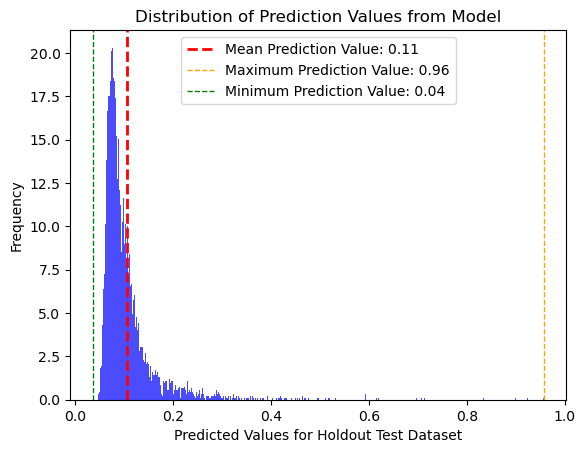

The mean predictive value for the test dataset is: 0.10507017406540482


In [15]:
plt.hist(test_dataset.predictions, bins=1000, density=True, alpha=0.7, color='blue')
plt.xlabel('Predicted Values for Holdout Test Dataset')
plt.ylabel('Frequency')
plt.title('Distribution of Prediction Values from Model')

mean_value = np.mean(test_dataset.predictions)
max_value = np.max(test_dataset.predictions)
min_value = np.min(test_dataset.predictions)


# Add mean line to the histogram
plt.axvline(mean_value, color='red', linestyle='dashed', linewidth=2, label=f'Mean Prediction Value: {mean_value:.2f}')

plt.axvline(max_value, color='orange', linestyle='dashed', linewidth=1, label=f'Maximum Prediction Value: {max_value:.2f}')

plt.axvline(min_value, color='green', linestyle='dashed', linewidth=1, label=f'Minimum Prediction Value: {min_value:.2f}')


# Display legend
plt.legend()

# Show the histogram
plt.show()

print('The mean predictive value for the test dataset is: {}'.format(mean_value))

As we can see here, our algorithm is hesitant to place much predictive weight behind any particular patient record, and so the majority of our predictions are centered near 0.1 and skew right. As the dataset is weighted heavily towards those who were not readmitted (i.e about 1 in 10 patients being readmitted), this makes sense.

We will therefore institute a prediction/rounding cutoff value lower than 0.5 to determine which records are predicted as being readmitted. As the mean prediction is around 10.5, using this value instead of 0.5 would likely predict around half of records as being classified as readmissions.

We will therefore use a average of these predictions is likely a good place to start. Let us try this value, as well with a few other values to see which cutoff value gives us the best statistical outcome.

As mentioned earlier, optimizing the Area Under the Curve (AUC) metric will be our highest priority, as this metric takes into account both false positives and false negatives.

#### Here we create new lists that will cut probabilities (ranging from 50% to 5%), while focusing on cutoff values close to the mean prediction of 10.5%. 

In [16]:
pred_50 = [1 if i>=0.5 else 0 for i in test_dataset["predictions"]]
pred_20 = [1 if i>=0.2 else 0 for i in test_dataset["predictions"]]
pred_12 = [1 if i>=0.12 else 0 for i in test_dataset["predictions"]]
pred_11 = [1 if i>=0.11 else 0 for i in test_dataset["predictions"]]
pred_105 = [1 if i>=0.10507 else 0 for i in test_dataset["predictions"]]
pred_1025 = [1 if i>=0.1025 else 0 for i in test_dataset["predictions"]]
pred_10 = [1 if i>=0.1 else 0 for i in test_dataset["predictions"]]
pred_05 = [1 if i>=0.05 else 0 for i in test_dataset["predictions"]]

#### Each list is now a series of 1/0 values

In [17]:
pred_105[0:20]

[0, 1, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0]

#### Here we list our different prediction lists together

In [18]:
list_of_prediction_lists = [pred_50, pred_20, pred_12, pred_11, pred_105, pred_1025, pred_10, pred_05]

#### Here we provde an accompanying name for each list, based off of the respective likelihood cutoff value applied to the list 

In [19]:
names_of_levels = ['50%', '20%', '12%', '11%', '10.571% (mean)', '10.25%', '10%', '5%']

#### Here we define the function to conduct our statistical analysis

In [20]:
def Linear_Learner_Statistical_Evaluation(probability_rounding_threshold_values, names_of_levels):
    
    '''The CSV_Reader() function takes different readmission predictions, based off of different likelihood roundoff 
    values, and computes different 
    
    Arguments 
    --------- 
    probability_rounding_threshold_values: A list of probabilities for each likelihood cutoff value
    subfolder: A list of names for each item of the probability_rounding_threshold_values list, representing 
        the implimented likelihood cutoff value
    
    Return
    ---------
    For each prediction list, the following is computed:
    -The likelihood cutoff value being used
    -The number of predicted positived
    -The accuracy of the predictions
    -The precision of the predictions
    -The recall of the predictions
    -The F1 score of the predictions
    -The ROC AUC score of the predictions
    '''
    
    for i, j in zip(probability_rounding_threshold_values, names_of_levels):
        y_test = test_dataset['readmitted']
        scores = precision_recall_fscore_support(y_test, i, average='macro', labels=np.unique(i))
        acc = accuracy_score(y_test, i)
        roc = roc_auc_score(y_test, i)
        positives = sum(i)
        
        print()
        print('The cutoff percentage being used for predictions is: {}'.format(j))
        print('Number of predicted readmissions: {}'.format(positives))
        print('Accuracy is: {}'.format(acc))
        print('Precision is: {}'.format(scores[0]))
        print('Recall is: {}'.format(scores[1]))
        print('F1 score is: {}'.format(scores[2]))     
        print('ROC AUC score (i.e. the metric of primary interest) is: {}'.format(roc))

#### Here we assess the statistical output for the predictions from each likelihood cutoff level

In [21]:
Linear_Learner_Statistical_Evaluation(list_of_prediction_lists, names_of_levels)


The cutoff percentage being used for predictions is: 50%
Number of predicted readmissions: 31
Accuracy is: 0.8803223239156387
Precision is: 0.730947268800036
Recall is: 0.5067153695699708
F1 score is: 0.4826434029477959
ROC AUC score (i.e. the metric of primary interest) is: 0.5067153695699708

The cutoff percentage being used for predictions is: 20%
Number of predicted readmissions: 559
Accuracy is: 0.8586350974930362
Precision is: 0.6002267559167502
Recall is: 0.5497832556063751
F1 score is: 0.5591592593659074
ROC AUC score (i.e. the metric of primary interest) is: 0.5497832556063751

The cutoff percentage being used for predictions is: 12%
Number of predicted readmissions: 2138
Accuracy is: 0.7576601671309192
Precision is: 0.5588339381749504
Recall is: 0.5931785608381931
F1 score is: 0.5633015593376747
ROC AUC score (i.e. the metric of primary interest) is: 0.5931785608381931

The cutoff percentage being used for predictions is: 11%
Number of predicted readmissions: 2771
Accuracy i

#### By looking at the above, it would appear that the highest AUC value is somewhere between 10.5% and 10%. Let us explore this more granularly...

In [22]:
pred_1024 = [1 if i>=0.1024 else 0 for i in test_dataset["predictions"]]
pred_102425 = [1 if i>=0.102425 else 0 for i in test_dataset["predictions"]]
pred_10245 = [1 if i>=0.10245 else 0 for i in test_dataset["predictions"]]
pred_102475 = [1 if i>=0.102475 else 0 for i in test_dataset["predictions"]]
pred_1025 = [1 if i>=0.1025 else 0 for i in test_dataset["predictions"]]
pred_102524 = [1 if i>=0.102524 else 0 for i in test_dataset["predictions"]]
pred_102525 = [1 if i>=0.102525 else 0 for i in test_dataset["predictions"]]
pred_102526 = [1 if i>=0.102526 else 0 for i in test_dataset["predictions"]]
pred_102575 = [1 if i>=0.102575 else 0 for i in test_dataset["predictions"]]
pred_1026 = [1 if i>=0.1026 else 0 for i in test_dataset["predictions"]]

#### Here we list our different prediction lists together

In [23]:
more_precise_rounding_threshold_predictions = [pred_1024, pred_102425, pred_10245, pred_102475, pred_102524, pred_1025, pred_102525, pred_102526, pred_102575, pred_1026]

#### Here we provde an accompanying name for each list, based off of the respective likelihood cutoff value applied to the list 

In [24]:
more_precise_names_of_levels = ['10.24%', '10.2425%','10.245%', '10.2475%','10.25%', '10.2524%', '10.2525%', '10.2526%', '10.2575', '10.26%']

In [25]:
Linear_Learner_Statistical_Evaluation(more_precise_rounding_threshold_predictions, more_precise_names_of_levels)


The cutoff percentage being used for predictions is: 10.24%
Number of predicted readmissions: 3431
Accuracy is: 0.6674293672900915
Precision is: 0.552143425542788
Recall is: 0.6108736120720899
F1 score is: 0.5316025094597477
ROC AUC score (i.e. the metric of primary interest) is: 0.6108736120720898

The cutoff percentage being used for predictions is: 10.2425%
Number of predicted readmissions: 3427
Accuracy is: 0.6676283326701155
Precision is: 0.5520578095148956
Recall is: 0.6106293113002117
F1 score is: 0.5315999016162261
ROC AUC score (i.e. the metric of primary interest) is: 0.6106293113002117

The cutoff percentage being used for predictions is: 10.245%
Number of predicted readmissions: 3426
Accuracy is: 0.6677278153601274
Precision is: 0.5520917526861314
Recall is: 0.6106858468045084
F1 score is: 0.5316693258758303
ROC AUC score (i.e. the metric of primary interest) is: 0.6106858468045085

The cutoff percentage being used for predictions is: 10.2475%
Number of predicted readmissi

From the above results, we can see that a cutoff value of 10.2525% (i.e. those predicted as being at 10.25% risk of readmission) gives us the greatest Area-Under-The-Curve value of 0.61108.

This can be roughly interpreted as: "Given a random readmitted/positive record, and random not-readmitted/negative record, the algorithm will correctly identify the positive record as being more likely to be readmitted than the negative record, 61% of the time.

This value of 0.61 is fairly close to the AUC value of 0.65 that we recieved from our best hyperparameter tuning session off of the validation data subset. This indicates that while there is likely some degree of overfitting present, generally, generally our model does a good job at providing generalizable, unbiased predictions across the entirity of the patient population.

Although the accuracy and precission have decreased due to our lower prediction cutoff point, we are able to predict these costly readmissions demonstratably better with the algorithm than without.

### 3.6 Evaluate Model

In [26]:
optimal_cutoff = pred_102525

In [27]:
from sklearn.metrics import confusion_matrix
from sklearn.utils.multiclass import unique_labels

def Plot_Confusion_Matrix(y_true, y_pred, classes,
                          normalize=False,
                          title=None, 
                          cmap=None):
    
    '''The Plot_Confusion_Matrix() function produces a confusion matrix with which to view our final results.
    
    Arguments 
    --------- 
    y_true: the actual readmission values for the test dataset
    y_pred: the predicted readmission values for the test dataset
    classes: The names for the outcome possibilities (i.e. readmitted/not readmitted) 
    title: chart title
    cmap: sets the color gradient
    
    Return
    ---------
    Returns the specified confusion matrix '''
    
    if not title:
        if normalize:
            title = 'Normalized confusion matrix'
            plt.cm.Greens
        else:
            title = 'Confusion matrix, without normalization'

    # Compute confusion matrix
    cm = confusion_matrix(y_true, y_pred)
    # Only use the labels that appear in the data
    classes = classes[unique_labels(y_true, y_pred)]
    if normalize:
        cm = cm.astype('float') / cm.sum(axis=1)[:, np.newaxis]

    fig, ax = plt.subplots()
    im = ax.imshow(cm, interpolation='nearest', cmap=cmap)
    ax.figure.colorbar(im, ax=ax)
    # We want to show all ticks...
    ax.set(xticks=np.arange(cm.shape[1]),
           yticks=np.arange(cm.shape[0]),
           # ... and label them with the respective list entries
           xticklabels=classes, yticklabels=classes,
           title=title,
           ylabel='Actual',
           xlabel='Predicted')

    # Rotate the tick labels and set their alignment.
    plt.setp(ax.get_xticklabels(), rotation=45, ha="right",
             rotation_mode="anchor")

    # Loop over data dimensions and create text annotations.
    fmt = '.2f' if normalize else 'd'
    thresh = cm.max() / 2.
    for i in range(cm.shape[0]):
        for j in range(cm.shape[1]):
            ax.text(j, i, format(cm[i, j], fmt),
                    ha="center", va="center",
                    color="white" if cm[i, j] > thresh else "black")
    fig.tight_layout()
    return ax


np.set_printoptions(precision=2)

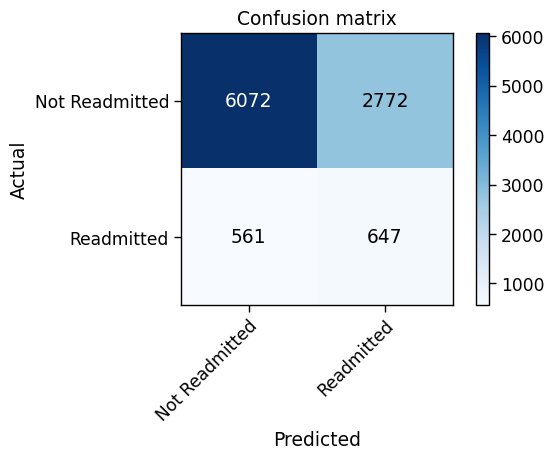

In [28]:
%matplotlib inline
sns.set_context("paper", font_scale=1.4)

y_test = test_dataset['readmitted']
y_pred = optimal_cutoff

class_names = np.array(['Not Readmitted', 'Readmitted'])

# Plot non-normalized confusion matrix
Plot_Confusion_Matrix(y_test, y_pred, classes=class_names,
                      title='Confusion matrix',
                      cmap=plt.cm.Blues)
plt.grid(False)
plt.show()

#### Our final predictive statistics:

In [29]:
Linear_Learner_Statistical_Evaluation([optimal_cutoff], ['10.2525% Cutoff'])


The cutoff percentage being used for predictions is: 10.2525% Cutoff
Number of predicted readmissions: 3419
Accuracy is: 0.6684241941902109
Precision is: 0.5523297522332764
Recall is: 0.6110815953345854
F1 score is: 0.5321555180656046
ROC AUC score (i.e. the metric of primary interest) is: 0.6110815953345853


For further discussion of these results, please see the accompanying assessment located here:<br>
https://wbst-bkt.s3.amazonaws.com/index.html